# intro

We need to create several plots:
- timeseries of heat season by season
- N^2 values as a timeseries for the whole ocean
- MLD for the frontal zones, above the front

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

# ignore memory warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
%run /home/mmurakami/crios_backups/an_helper_functions/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



# create a timeseries of MLD

In [3]:
mymsk = np.zeros((ny,nx))
idxs = np.where(mskBasin == 6)

for i,j in zip (idxs[0],idxs[1]):
    mymsk[i,j] = 1

In [4]:
# calculate the sea ice edge for 1 and 2
thresh = .15  # 15% sea ice coverage as Barton

fig = plt.figure(figsize=(8,5))

# plot the basins, color by label
landmsk = np.zeros((ny,nx))
landmsk[np.isnan(hfC[0])] = 2
landmsk[hfC[0] == 1] = np.nan

# add the land
# plt.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap='RdBu')

<Figure size 800x500 with 0 Axes>

In [5]:
# calculate the sea ice edge for 1 and 2
thresh = .15  # 15% sea ice coverage as Barton

fig = plt.figure(figsize=(8,5))

# plot the basins, color by label
landmsk = np.zeros((ny,nx))
landmsk[np.isnan(hfC[0])] = 2
landmsk[hfC[0] == 1] = np.nan

# add the land
# plt.pcolormesh(get_aste_tracer(hfC,nfx,nfy)[0],cmap='RdBu')

<Figure size 800x500 with 0 Axes>

In [14]:
# define the years of this that we want to read from
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

allyears = np.arange(2003,2018,1)

In [7]:
mymsk = mygrid['hFacC'] * np.tile(mymsk[np.newaxis,:,:],(50,1,1))

In [12]:
mymsk[mymsk == 0] = np.nan

# we need to identify a mask for the polar front (we did this in Lind_PF_analysis)

In [15]:
# get the theta and salt for all years

all_SST = np.full((len(allyears),12,ny,nx),np.nan)

iy = 0
it = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    # get the theta/salt values
    thisyear_SST = np.full((len(tsstr),ny,nx),np.nan)  # one year length
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'state_3d_set1'
        meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_state_3d_set1["fldList"])
        varnames = np.array(["THETA"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETAi,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
    
        thisyear_SST[i,:,:] = np.reshape(THETAi,(nz,ny,nx))[0] # just add SST

    # get theta and salt alone so we can use for the freshwater content
    all_SST[iy,:,:,:] = thisyear_SST
    
    iy += 1

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [20]:
DXG = get_aste_tracer(mygrid['DXG'],nfx,nfy)[0]
DYG = get_aste_tracer(mygrid['DYG'],nfx,nfy)[0]
DXG.shape

(900, 540)

In [22]:
# create a timeseries mask of the PF
PF_mask = np.zeros((len(allyears),900,540))


# Define DJFM indices (December=11, January=0, February=1, March=2)
djf_indices = [11, 0, 1]
mam_indices = [2,3,4]
jja_indices = [5,6,7]
son_indices = [8,9,10]


# Loop through years and plot anomalies with PF overlay
for year_idx, year in enumerate(allyears):

    # Compute DJFM SST gradient mask (`grad_T_masked`) for this year
    SST_DJFM = np.nanmean(all_SST[year_idx, djfm_indices], axis=0)  # DJFM SST
    tracerSST = get_aste_tracer(SST_DJFM * hfC, nfx, nfy)[0]

    # Compute SST gradient
    dTdx = np.zeros_like(tracerSST)
    dTdx[:, 1:-1] = (tracerSST[:, 2:] - tracerSST[:, :-2]) / (DXG[:, 2:] + DXG[:, :-2])
    
    dTdy = np.zeros_like(tracerSST)
    dTdy[1:-1, :] = (tracerSST[2:, :] - tracerSST[:-2, :]) / (DYG[2:, :] + DYG[:-2, :])

    grad_T = np.sqrt(dTdx**2 + dTdy**2)  # Compute magnitude
    mask = (tracerSST > -2) & (tracerSST < 4)  # Mask PF-relevant SST range
    grad_T_masked = grad_T * mask * 1000  # Convert to °C/km
    grad_T_masked = np.where(grad_T_masked>0.005,1,0) # set some threshold
    print(grad_T_masked.shape)
    PF_mask[year_idx] = grad_T_masked

(900, 540)
(900, 540)
(900, 540)
(900, 540)
(900, 540)
(900, 540)
(900, 540)
(900, 540)
(900, 540)
(900, 540)
(900, 540)
(900, 540)
(900, 540)
(900, 540)
(900, 540)


In [24]:
# aste_tracer2compact(DYG,nfx,nfy).shape

In [28]:
# read the temperature and salt profile for this annual anomaly

# do this by looping through the salt and heat -- we want to make an average of these as depth
theta_dist1 = np.zeros((len(allyears),12,nz))
salt_dist1 = np.zeros((len(allyears),12,nz))

# do indexing in years for the layers
iy = 0
for year in allyears:
    print(year)

    mymskpf = aste_tracer2compact(PF_mask[iy],nfx,nfy)[0]

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ##########################################################################################
    # get the theta/salt values
    # we also want salt to do the FW content
    # we want temperature and salt
    THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
    SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'budg3d_snap_set2'
        meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_budg3d_snap_set2["fldList"])
        varnames = np.array(["THETADR","SALTDR"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETADRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
        SALTDRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])  # degC.m
    
        THETADR[i,:,:,:] = np.reshape(THETADRi,(nz,ny,nx))
        SALTDR[i,:,:,:] = np.reshape(SALTDRi,(nz,ny,nx))

    for i in range(len(datetimes)):
        # for calculating heat content:
            # weighted theta * rcp = J/m^2 which is the depth-weighted heat content of a cell
            # integrate over all values within the depth interval of choice
        # do the depth meaning for theta
        thisTHETA = THETADR[i]/DRF3d/mygrid['hFacC'] * mymskpf[np.newaxis,:,:]    # degC
        thisTHETA[thisTHETA == 0] = np.nan   # this was messing up averaging without this precaution
        theta_dist1[iy,i,:] = np.nanmean(thisTHETA, axis = (1,2))  # depth average of shape nz

        # do the depth averaging for freshwater
        thisSALT = SALTDR[i]/DRF3d/mygrid['hFacC'] * mymskpf[np.newaxis,:,:]    # PSU
        thisSALT[thisSALT == 0] = np.nan
        salt_dist1[iy,i,:] = np.nanmean(thisSALT, axis = (1,2))  # depth average of shape nz

    iy += 1

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


Profiles saved to 'profiles_100m_all_years.png'


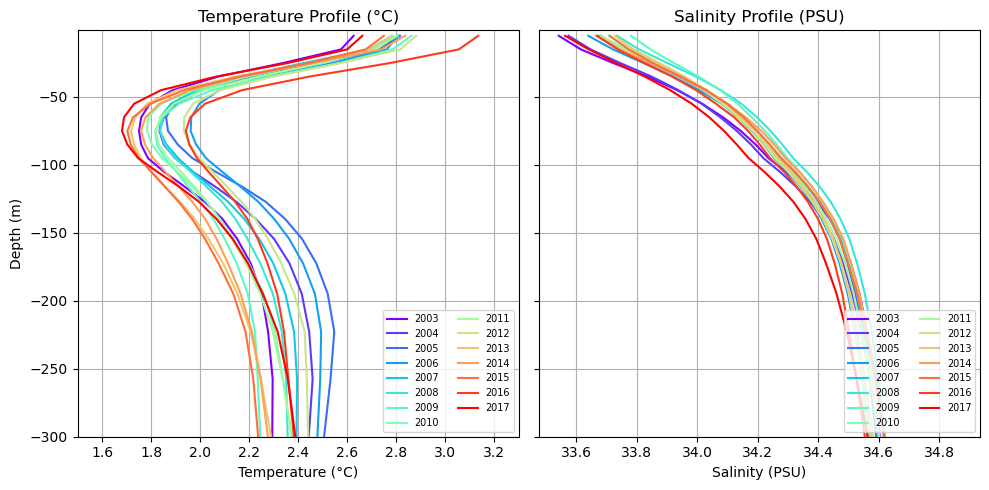

In [38]:


# Define colors for different years
cmap = plt.get_cmap("rainbow", len(allyears))  # Use a colormap for year differentiation

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# **Plot Temperature Profiles for Each Year**
ax = axes[0]
for i, year in enumerate(allyears):
    ax.plot(np.nanmean(theta_dist1[i], axis=0), mygrid['RC'], label=str(year), color=cmap(i))

ax.set_ylim(-300, -1)
ax.set_xlim(1.5,3.3)
ax.set_title("Temperature Profile (°C)")
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Depth (m)")
ax.legend(fontsize=7, loc="lower right", ncol=2)
ax.grid()

# **Plot Salinity Profiles for Each Year**
ax = axes[1]
for i, year in enumerate(allyears):
    ax.plot(np.nanmean(salt_dist1[i], axis=0), mygrid['RC'], label=str(year), color=cmap(i))

ax.set_ylim(-300, -1)
ax.set_title("Salinity Profile (PSU)")
ax.set_xlabel("Salinity (PSU)")
ax.legend(fontsize=7, loc="lower right", ncol=2)
ax.grid()

# Adjust layout to prevent overlap
plt.tight_layout()

# # **Plot Salinity Profiles for Each Year**
# ax = axes[2]
# for i, year in enumerate(allyears):
#     mysalt = np.nanmean(salt_dist1[i], axis=0)
#     mytemp = np.nanmean(theta_dist1[i], axis=0)
#     myrho = gsw.rho(mysalt,mytemp,0)
#     ax.plot(myrho-1000, mygrid['RC'], label=str(year), color=cmap(i))

# ax.set_ylim(-300, -1)
# ax.set_title("Density Profile (kg/m^3 - 1000)")
# ax.set_xlabel("Density (kg/m^3 - 1000)")
# ax.legend(fontsize=7, loc="lower right", ncol=2)
# ax.grid()

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
# plt.savefig("figs/profiles_100m_all_years.png", dpi=300)

print("Profiles saved to 'profiles_100m_all_years.png'")
plt.show()


In [77]:
theta_dist1.shape
np.nanmean(theta_dist1[0], axis=0).shape

(50,)

2003 -85.02499999999999
2004 -85.02499999999999
2005 -85.02499999999999
2006 -95.095
2007 -95.095
2008 -85.02499999999999
2009 -95.095
2010 -85.02499999999999
2011 -95.095
2012 -85.02499999999999
2013 -95.095
2014 -85.02499999999999
2015 -85.02499999999999
2016 -85.02499999999999
2017 -85.02499999999999
Profiles saved to 'profiles_100m_all_years.png'


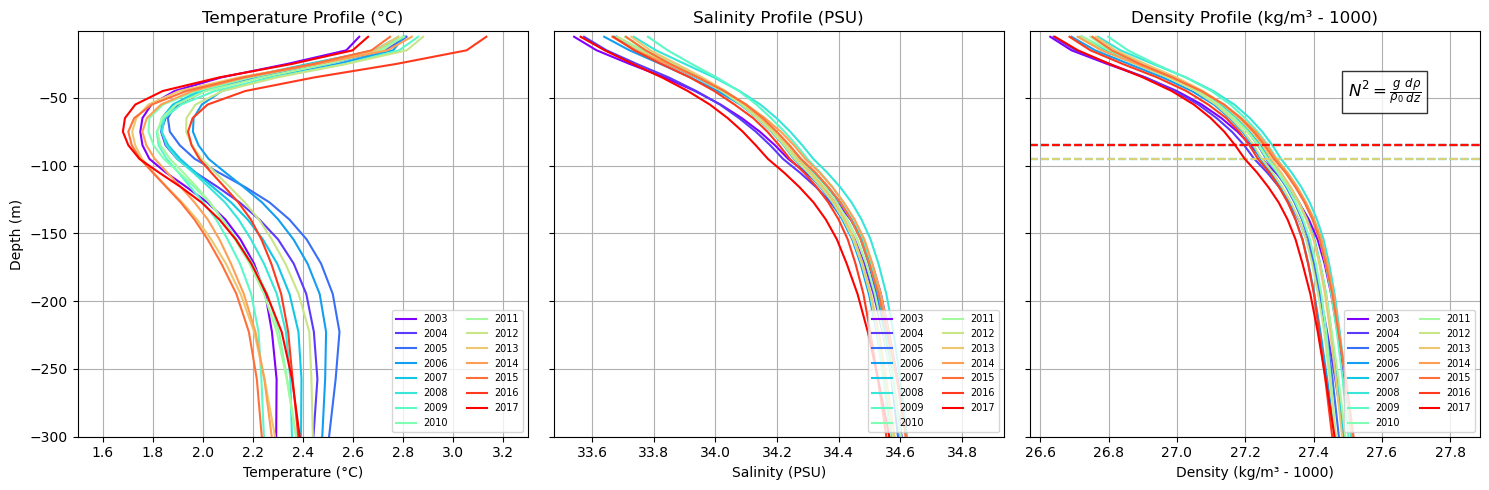

In [51]:
# Define colors for different years
cmap = plt.get_cmap("rainbow", len(allyears))  # Use a colormap for year differentiation

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)  # Add a third panel for density

# **Plot Temperature Profiles for Each Year**
ax = axes[0]
max_strat_depths = []  # Store max stratification depth for each year

for i, year in enumerate(allyears):
    mytemp = np.nanmean(theta_dist1[i], axis=0) # annual average
    ax.plot(mytemp, mygrid['RC'], label=str(year), color=cmap(i))

ax.set_ylim(-300, -1)
ax.set_xlim(1.5, 3.3)
ax.set_title("Temperature Profile (°C)")
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Depth (m)")
ax.legend(fontsize=7, loc="lower right", ncol=2)
ax.grid()

# **Plot Salinity Profiles for Each Year**
ax = axes[1]
for i, year in enumerate(allyears):
    mysalt = np.nanmean(salt_dist1[i], axis=0)
    ax.plot(mysalt, mygrid['RC'], label=str(year), color=cmap(i))

ax.set_ylim(-300, -1)
# ax.set_xlim(34.6, 35.2)
ax.set_title("Salinity Profile (PSU)")
ax.set_xlabel("Salinity (PSU)")
ax.legend(fontsize=7, loc="lower right", ncol=2)
ax.grid()

# **Compute Density and Brunt-Väisälä Frequency (N²)**
ax = axes[2]
for i, year in enumerate(allyears):
    mysalt = np.nanmean(salt_dist1[i], axis=0)
    mytemp = np.nanmean(theta_dist1[i], axis=0)
    myrho = gsw.rho(mysalt, mytemp, 0)  # Compute density
    drho_dz = np.gradient(myrho, mygrid['RC'])  # Compute density gradient
    N2 = (9.81 / 1027) * drho_dz  # Compute N²

    # Identify the depth of maximum stratification in the upper 100m
    mask = mygrid['RC'] >= -100  # Limit to upper 100m
    if np.any(mask):
        max_strat_depth = mygrid['RC'][np.argmax(N2[mask])]  # Depth where N² is max
        max_strat_depths.append(max_strat_depth)

    ax.plot(myrho - 1000, mygrid['RC'], label=str(year), color=cmap(i))

    # Overlay max stratification depth
    print(year,max_strat_depth)
    ax.axhline(y=max_strat_depth, color=cmap(i), linestyle="--", alpha=0.8)

ax.set_ylim(-300, -1)

# Add equation annotation
ax.text(27.5, -50, r"$N^2 = \frac{g}{\rho_0} \frac{d\rho}{dz}$", 
        fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
ax.set_title("Density Profile (kg/m³ - 1000)")
ax.set_xlabel("Density (kg/m³ - 1000)")
ax.legend(fontsize=7, loc="lower right", ncol=2)
ax.grid()

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig("figs/profiles_100m_all_years.png", dpi=300)

print("Profiles saved to 'profiles_100m_all_years.png'")
plt.show()


2017 -5.0
2017 -95.095
2017 -95.095
2017 -5.0
2017 -5.0
2017 -95.095
2017 -95.095
2017 -5.0
2017 -5.0
2017 -95.095
2017 -95.095
2017 -5.0
Profiles saved to 'profiles_100m_seasonal.png'


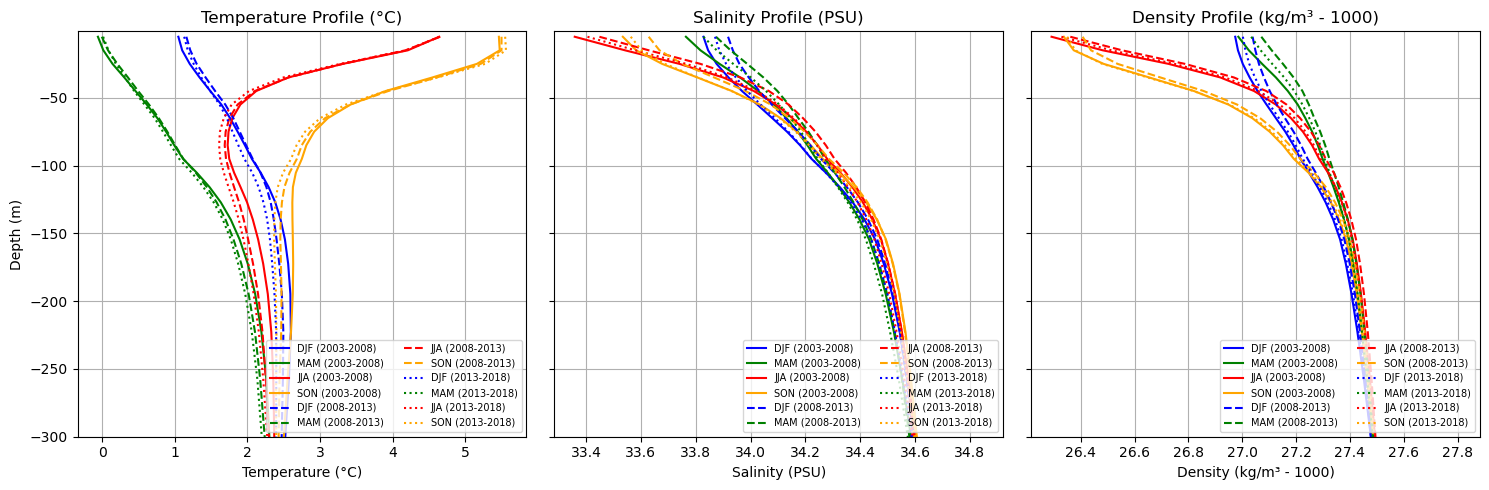

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import gsw  # TEOS-10 Gibbs Seawater package

# Define seasonal indices
djf_indices = [11, 0, 1]  # Winter
mam_indices = [2, 3, 4]   # Spring
jja_indices = [5, 6, 7]   # Summer
son_indices = [8, 9, 10]  # Fall

seasons = {'DJF': djf_indices, 'MAM': mam_indices, 'JJA': jja_indices, 'SON': son_indices}
colors = ['b', 'g', 'r', 'orange']  # Colors for each season
period_labels = ["2003-2008", "2008-2013", "2013-2018"]  # Year periods

# Define groups of years
year_groups = [range(0, 5), range(5, 10), range(10, 15)]  # Indices 0-5, 5-10, 10-15

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)  # Temperature, Salinity, Density

# **Temperature Profiles for Each Season & Year Group**
ax = axes[0]
for j, (period, years) in enumerate(zip(period_labels, year_groups)):
    for i, (season, indices) in enumerate(seasons.items()):
        temp_seasonal = np.nanmean([np.nanmean(theta_dist1[y, indices, :], axis=0) for y in years], axis=0)
        ax.plot(temp_seasonal, mygrid['RC'], label=f"{season} ({period})", color=colors[i], linestyle=['-', '--', ':'][j])

ax.set_ylim(-300, -1)
# ax.set_xlim(1.5, 3.3)
ax.set_title("Temperature Profile (°C)")
ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Depth (m)")
ax.legend(fontsize=7, loc="lower right", ncol=2)
ax.grid()

# **Salinity Profiles**
ax = axes[1]
for j, (period, years) in enumerate(zip(period_labels, year_groups)):
    for i, (season, indices) in enumerate(seasons.items()):
        salt_seasonal = np.nanmean([np.nanmean(salt_dist1[y, indices, :], axis=0) for y in years], axis=0)
        ax.plot(salt_seasonal, mygrid['RC'], label=f"{season} ({period})", color=colors[i], linestyle=['-', '--', ':'][j])

ax.set_ylim(-300, -1)
ax.set_title("Salinity Profile (PSU)")
ax.set_xlabel("Salinity (PSU)")
ax.legend(fontsize=7, loc="lower right", ncol=2)
ax.grid()

# **Density & Brunt-Väisälä Frequency (N²)**
ax = axes[2]
for j, (period, years) in enumerate(zip(period_labels, year_groups)):
    for i, (season, indices) in enumerate(seasons.items()):
        salt_seasonal = np.nanmean([np.nanmean(salt_dist1[y, indices, :], axis=0) for y in years], axis=0)
        temp_seasonal = np.nanmean([np.nanmean(theta_dist1[y, indices, :], axis=0) for y in years], axis=0)
        rho_seasonal = gsw.rho(salt_seasonal, temp_seasonal, 0)

        drho_dz = np.gradient(rho_seasonal, mygrid['RC'])
        N2 = (9.81 / 1027) * drho_dz

        mask = mygrid['RC'] >= -100# mygrid['RC']< -5e0
        if np.any(mask):
            max_strat_depth = mygrid['RC'][np.argmax(N2[mask])]

        ax.plot(rho_seasonal - 1000, mygrid['RC'], label=f"{season} ({period})", color=colors[i], linestyle=['-', '--', ':'][j])

        # Overlay max stratification depth
        print(year,max_strat_depth)
        #ax.axhline(y=max_strat_depth, color=colors[i], linestyle="--", alpha=0.8)

ax.set_ylim(-300, -1)
ax.set_title("Density Profile (kg/m³ - 1000)")
ax.set_xlabel("Density (kg/m³ - 1000)")
ax.legend(fontsize=7, loc="lower right", ncol=2)
ax.grid()

# Add equation annotation
# ax.text(27.5, -50, r"$N^2 = \frac{g}{\rho_0} \frac{d\rho}{dz}$", fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# Adjust layout
plt.tight_layout()
plt.savefig("figs/profiles_100m_seasonal2.png", dpi=300)
print("Profiles saved to 'profiles_100m_seasonal.png'")

plt.show()

In [82]:
mygrid['RC']

array([-5.000000e+00, -1.500000e+01, -2.500000e+01, -3.500000e+01,
       -4.500000e+01, -5.500000e+01, -6.500000e+01, -7.500500e+01,
       -8.502500e+01, -9.509500e+01, -1.053100e+02, -1.158700e+02,
       -1.271500e+02, -1.397400e+02, -1.544700e+02, -1.724000e+02,
       -1.947350e+02, -2.227100e+02, -2.574700e+02, -2.999300e+02,
       -3.506800e+02, -4.099300e+02, -4.774700e+02, -5.527100e+02,
       -6.347350e+02, -7.224000e+02, -8.144700e+02, -9.097400e+02,
       -1.007155e+03, -1.105905e+03, -1.205535e+03, -1.306205e+03,
       -1.409150e+03, -1.517095e+03, -1.634175e+03, -1.765135e+03,
       -1.914150e+03, -2.084035e+03, -2.276225e+03, -2.491250e+03,
       -2.729250e+03, -2.990250e+03, -3.274250e+03, -3.581250e+03,
       -3.911250e+03, -4.264250e+03, -4.640250e+03, -5.039250e+03,
       -5.461250e+03, -5.906250e+03])

# heat content anomaly of the four seasons individually

In [52]:
all_SIarea = np.full((len(allyears),12,ny,nx),np.nan)


iy = 0
it = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    thisyear_SIarea = np.full((len(tsstr),ny,nx),np.nan)  # one year length
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'budg2d_snap_set1'
        meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_budg2d_snap_set1["fldList"])
        varnames = np.array(["SIarea"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        SIareai,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
    
        thisyear_SIarea[i,:,:] = np.reshape(SIareai,(ny,nx)) # just add SST

    # get theta and salt alone so we can use for the freshwater content
    all_SIarea[iy,:,:,:] = thisyear_SIarea
    
    iy += 1

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [61]:
si_time = np.nanmean(all_SIarea,axis=1)
test = np.array([])
for i, year in enumerate(allyears):
    print(year,np.nansum(si_time[i]* mymsk))
    test = np.append(test,np.nansum(si_time[i]* mymsk))

2003 39399.49577990397
2004 33361.343476850125
2005 23732.959041654172
2006 17429.98769741159
2007 16855.168215620455
2008 19700.16529414232
2009 19973.708769527675
2010 21417.80072187664
2011 20978.70884826324
2012 10765.694811495423
2013 16352.010341741952
2014 20824.274323796664
2015 21532.225414332246
2016 10680.403683091961
2017 17049.17502647276


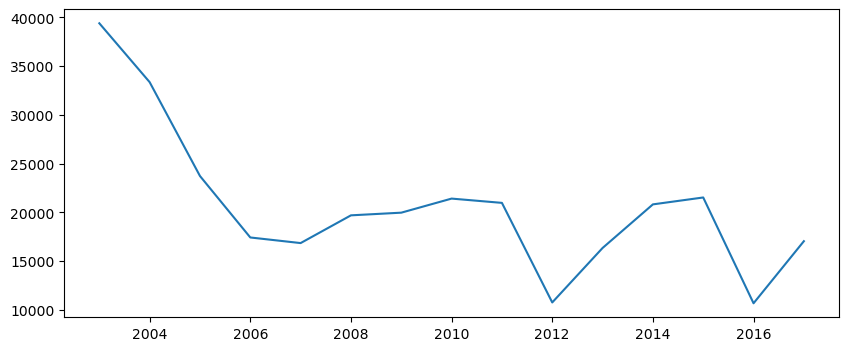

In [62]:
plt.plot(allyears,test)

# let's recreate the lind timeseries just season by season

In [63]:
mymsk = np.load('/home/mmurakami/crios_backups/ASTE_270/Pemberton_BarentsSpaper/ASTE_figs/mask_Lind.npz')
mymsk = mymsk['msk1']
msk1 = mymsk

In [66]:
# also plot underneath this the average profiles
hfC = mygrid['hFacC']
hfC0 = hfC[0]

# Create a copy to modify
hfC_modified = hfC.copy()
hfC0_copy = np.full((ny, nx), np.nan)
hfC0_copy[np.isnan(hfC0)] = 1

# Modify only the copied version
hfC_modified[0] = hfC0_copy

In [67]:
# np.cumsum(mygrid['DRF'][0:10])
heat_content = np.full((len(allyears),12,ny,nx),np.nan)
fw_content = np.full((len(allyears),12,ny,nx),np.nan)

In [89]:
# loop through the years to create the timeseries
# alldatetimes = np.array([])
# FW_times = np.array([])
# Heat_times = np.array([])  # this does not make sense as variable name
dstart = 10
dterm = 50

# sref = 36.25
# tref = -1.95

# from Lind Paper
sref = 35
tref = 0

iy = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    # get the theta/salt values
    # we also want salt to do the FW content
    # we want temperature and salt
    THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
    SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'budg3d_snap_set2'
        meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_budg3d_snap_set2["fldList"])
        varnames = np.array(["THETADR","SALTDR"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETADRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
        SALTDRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])  # degC.m
    
        THETADR[i,:,:,:] = np.reshape(THETADRi,(nz,ny,nx))
        SALTDR[i,:,:,:] = np.reshape(SALTDRi,(nz,ny,nx))

    # get theta and salt alone so we can use for the freshwater content
    THETA = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
    SALT = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
        THETA[i,:,:,:] = THETADR[i,:,:,:]/DRF3d/hfC_modified  # degC
        SALT[i,:,:,:]  = SALTDR[i,:,:,:]/DRF3d/hfC_modified   # PSU

    ##########################################################################################
    # get the heat content
    for i in range(len(datetimes)):
        # for calculating heat content:
            # weighted theta * rcp = J/m^2 which is the depth-weighted heat content of a cell
            # integrate over all values within the depth interval of choice
        
        thisTHETA = THETADR[i]/DRF3d/mygrid['hFacC'] * mymsk[np.newaxis,:,:]    # degC
        thisheat = (thisTHETA - tref) * myparms['rcp']   # degC * J/m^3.degC = J/m^3
        thisheat = thisheat * DRF3d  # J/m³ * m = J/m²

        # select heat based on the AW layer
        thisheat = thisheat[dstart:dterm]   # upper mygrid['DRF'][:dterm] m
        heat_content_2D = np.nansum(thisheat,axis=0) * mymsk         # vertical integration (J/m^2)

        # do the spatial averaging
        # area_masked = RAC * mymsk   # m^2
        # heat_content_avg = np.nansum(heat_content_2D * area_masked)/np.nansum(area_masked)   # MJ/m^2 * m^2/m^2
        heat_content[iy,i,:,:] = heat_content_2D * 1e-6  # MJ/m^2

    ##########################################################################################
    # get the freshwater content values
    # set up for time averaging
    # filter = drf3d.copy() * mygrid['hFacC']
    # filter[filter >= 254] = np.nan
    # filter[filter < 254] = 1
    FWcontent = np.full((len(tsstr),ny,nx),np.nan)
    
    for i in range(len(tsstr)): 
        # for calculating freshwater content:
            # FW volume * (1- salinity/reference salinity)    m^3
            # integrate over surface to mygrid['DRF'][:dterm] m based on the np.where(np.cumsum(mygrid['DRF'])<X meters deep)
            # look at the time average of this
        
        # do step 1 to get FW volume and only look at the values at less than X m
        FWvol = ((sref - SALT[i])/sref) * DRF3d # m
        
        FWvol = FWvol[dstart:dterm]    # leaving as m^3 here
        
        # vertically integrate
        FWcontent_2D = np.nansum(FWvol,axis=0) * mymsk          # vertical integration, m
        # area_masked = RAC * mymsk
        # FW_content_avg = np.nansum(FWcontent_2D * area_masked)/np.nansum(area_masked)

        # add as a map to the bigger array
        fw_content[iy,i,:,:] = FWcontent_2D

    print()
    iy += 1

2003

2004

2005

2006

2007

2008

2009

2010

2011

2012

2013

2014

2015

2016

2017



In [90]:
heat_content_time = np.nanmean(heat_content,axis=(2,3))
fw_content_time = np.nanmean(fw_content,axis=(2,3))

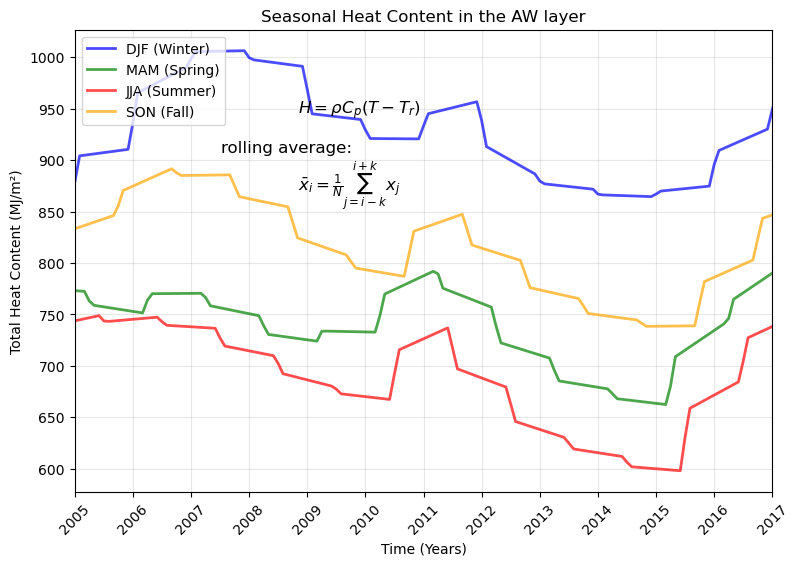

In [92]:

# Define time axis (assuming monthly time steps over 15 years)
time = np.arange(0, 15 * 12, 1)  # Months

# Extract seasonal indices
DJF_indices = np.array([i for i in range(len(time)) if i % 12 in [11, 0, 1]])  # Dec-Jan-Feb
MAM_indices = np.array([i for i in range(len(time)) if i % 12 in [2, 3, 4]])   # Mar-Apr-May
JJA_indices = np.array([i for i in range(len(time)) if i % 12 in [5, 6, 7]])   # Jun-Jul-Aug
SON_indices = np.array([i for i in range(len(time)) if i % 12 in [8, 9, 10]])  # Sep-Oct-Nov

# Extract seasonal heat content
heat_DJF = heat_content_time.flatten()[DJF_indices]
heat_MAM = heat_content_time.flatten()[MAM_indices]
heat_JJA = heat_content_time.flatten()[JJA_indices]
heat_SON = heat_content_time.flatten()[SON_indices]

# Define time axis for each season (adjusted to match correct months)
time_DJF = time[DJF_indices]
time_MAM = time[MAM_indices]
time_JJA = time[JJA_indices]
time_SON = time[SON_indices]

# Apply rolling mean (smoothing)
window_size = 12  # 12-month smoothing
heat_DJF_smooth = pd.Series(heat_DJF).rolling(window=window_size, center=True, min_periods=1).mean()
heat_MAM_smooth = pd.Series(heat_MAM).rolling(window=window_size, center=True, min_periods=1).mean()
heat_JJA_smooth = pd.Series(heat_JJA).rolling(window=window_size, center=True, min_periods=1).mean()
heat_SON_smooth = pd.Series(heat_SON).rolling(window=window_size, center=True, min_periods=1).mean()

# Create figure
fig, ax = plt.subplots(figsize=(9, 6))

# Plot each season's heat content
ax.plot(time_DJF, heat_DJF_smooth, color="blue", label="DJF (Winter)", alpha=0.7, linewidth=2)
ax.plot(time_MAM, heat_MAM_smooth, color="green", label="MAM (Spring)", alpha=0.7, linewidth=2)
ax.plot(time_JJA, heat_JJA_smooth, color="red", label="JJA (Summer)", alpha=0.7, linewidth=2)
ax.plot(time_SON, heat_SON_smooth, color="orange", label="SON (Fall)", alpha=0.7, linewidth=2)

# Label axes
ax.set_xlabel("Time (Years)")
ax.set_ylabel("Total Heat Content (MJ/m²)")
ax.set_title("Seasonal Heat Content in the AW layer")

# X-axis ticks
xtick_positions = np.arange(0, 15 * 12, 12)  # Every 12 months
xtick_labels = np.arange(2003, 2018)  # Years from 2003 to 2018
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, rotation=45)  # Rotate for readability
ax.set_xlim(0, 15 * 12)
ax.grid(alpha=0.3)

# Add equations as text annotations
eq1 = r"$F = \frac{S_{r} - S}{S_{r}}$"
eq2 = r"$H = \rho C_p (T - T_{r})$"
eq3 = r"$\bar{x}_i = \frac{1}{N} \sum_{j=i-k}^{i+k} x_j$"  # Rolling mean equation

# ax.text(0.32, 0.92, eq1, transform=ax.transAxes, fontsize=12, verticalalignment='top', color='black')
ax.text(0.32, 0.85, eq2, transform=ax.transAxes, fontsize=12, verticalalignment='top', color='black')
ax.text(0.21, 0.76, "rolling average:", transform=ax.transAxes, fontsize=12, verticalalignment='top', color='black')
ax.text(0.32, 0.72, eq3, transform=ax.transAxes, fontsize=12, verticalalignment='top', color='black')

# Legends
ax.legend(loc="upper left")

# Y-axis limits
# ax.set_ylim(-120, 500)
ax.set_xlim(24,168)

# Show plot
plt.savefig("figs/seasonal_heat_changes_AWlayer.png",dpi=300)
plt.show()


In [73]:
xtick_positions

array([  0,  12,  24,  36,  48,  60,  72,  84,  96, 108, 120, 132, 144,
       156, 168])